In [40]:
%matplotlib inline
import argparse
import os
import random
import argparse
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image

In [3]:
# set a manual seed to prevent different result while every running

manualSeed = 999
print("Random seed:", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random seed: 999


In [41]:
data_root = "./CAN_image_dataset(L)/"    # dataset root
workers = 1                 # using thread numbers
batch_size = 128            # batch_size
nc = 1                      # number of channel from input images
num_epochs = 100             # number of training epochs
lr = 0.0001                 # learning rate
beta1 = 0.5                 # hyperparameter for adam optimizer
ngpu = 1                    # number of available gpu

In [43]:
dataset = dset.ImageFolder(root=data_root,
                           transform=transforms.Compose([
                               transforms.Grayscale(1),
                               transforms.ToTensor(),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size,shuffle=False,num_workers=workers)
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

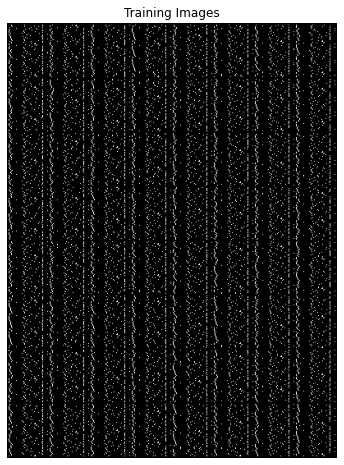

In [33]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('Training Images')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2,normalize=True).cpu(),(1,2,0)))

In [7]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()

    def forward(self, x):
        # Do your print / debug stuff here
        print(x)
        return x

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
# v1 : except nn.BatchNorm2d(channel size)

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Input : N x channel noise x 1 x 1
            nn.ConvTranspose2d(256,512,(4,3),stride=1,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # second layer
            nn.ConvTranspose2d(512,256,4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # third layer
            nn.ConvTranspose2d(256,128,4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # fourth layer,
            nn.ConvTranspose2d(128,64,4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # Final layer
            nn.ConvTranspose2d(64,1,4,stride=2,padding=1,bias=False),
            nn.Tanh()
        )
    def forward(self,input):
        return self.main(input)

In [10]:
netG = Generator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG,list(range(ngpu)))

netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(256, 512, kernel_size=(4, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [34]:
class Discriminator(nn.Module):
    def __init__(self,ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu,
        self.main = nn.Sequential(
            nn.Conv2d(1,1,(4,3),stride=(2,1),padding=1,bias=False),
            nn.BatchNorm2d(1),
            nn.ReLU(True),
            nn.Conv2d(1,1,(4,3),stride=(2,1),padding=1,bias=False),
            nn.BatchNorm2d(1),
            nn.ReLU(True),
            nn.Conv2d(1,1,(16,48),stride=1,padding=0,bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)

In [35]:
netD = Discriminator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD,list(range(ngpu)))

netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 1, kernel_size=(4, 3), stride=(2, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(1, 1, kernel_size=(4, 3), stride=(2, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(1, 1, kernel_size=(16, 48), stride=(1, 1), bias=False)
    (7): Sigmoid()
  )
)


In [36]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64,256,1,1,device=device)

real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr = lr, betas = (beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr = lr, betas = (beta1, 0.999))

In [44]:
# train process0
from tqdm import tqdm
import time

# save losses to check training state
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

# iterate epoch
for epoch in tqdm(range(num_epochs)):
    # iterate batch in an epoch
    for i ,data in enumerate(dataloader,0):
        ####################
        # (1) update discriminator network : maximize log(D(x)) + log(1 - D(G(z))))
        ####################
        # @@train real data@@
        netD.zero_grad()
        # Adapt to the size of the batches or the device to be used
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label,
                           dtype=torch.float, device= device)
        # pass batch composed real data to D
        output = netD(real_cpu).view(-1)
        # get losses
        errD_real = criterion(output,label)
        # calculate degree of change while doing backpropagation
        errD_real.backward()
        D_x = output.mean().item()

        # @@ train fake data @@
        # Generate latent space vector used in Generator
        noise = torch.randn(b_size,256,1,1,device=device)
        # Generate fake image using G
        fake = netG(noise)
        label.fill_(fake_label)
        # Discriminate truth of data using D
        output = netD(fake.detach()).view(-1)
        # Calculate losses of D
        errD_fake = criterion(output,label)
        # Calculate changes through backpropagation and accumulate changes which get before
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # add losses which get from both fake image and real image
        # At this time, errD is not used in backpropagation, but is used when reporting the learning state afterwards.
        errD = errD_fake +errD_real

        # Update D
        optimizerD.step()

        ###################
        # (2) Update G network : maximize log(D(G(z)))
        ###################
        netG.zero_grad()
        label.fill_(real_label) # we use real label to get losses of Generator
        # Pass fake data to D again because we update D just now
        # At this time, G didn't update, but we get different value because D update
        output = netD(fake).view(-1)
        # get losses of G
        errG = criterion(output,label)
        # Calculate changes of G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        

        # print training state
        if i % 50 == 0:
             print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # save losses to draw graph later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # save return value of G passed fixed noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1



Starting Training Loop...


  0%|          | 0/100 [00:00<?, ?it/s]

[0/100][0/121]	Loss_D: 0.5813	Loss_G: 1.4367	D(x): 0.7780	D(G(z)): 0.2339 / 0.2377
[0/100][50/121]	Loss_D: 0.9419	Loss_G: 1.1290	D(x): 0.7214	D(G(z)): 0.3948 / 0.3234
[0/100][100/121]	Loss_D: 1.9072	Loss_G: 0.5371	D(x): 0.4341	D(G(z)): 0.5295 / 0.5844


  1%|          | 1/100 [00:07<12:31,  7.59s/it]

[1/100][0/121]	Loss_D: 1.6536	Loss_G: 0.6040	D(x): 0.5118	D(G(z)): 0.5134 / 0.5466
[1/100][50/121]	Loss_D: 1.3198	Loss_G: 0.8719	D(x): 0.6158	D(G(z)): 0.4731 / 0.4182
[1/100][100/121]	Loss_D: 0.8399	Loss_G: 1.2023	D(x): 0.6745	D(G(z)): 0.2859 / 0.3005


  2%|▏         | 2/100 [00:14<11:49,  7.24s/it]

[2/100][0/121]	Loss_D: 1.1575	Loss_G: 0.9181	D(x): 0.6224	D(G(z)): 0.3930 / 0.3993
[2/100][50/121]	Loss_D: 1.2963	Loss_G: 1.0344	D(x): 0.6605	D(G(z)): 0.5222 / 0.3555
[2/100][100/121]	Loss_D: 0.9611	Loss_G: 1.0509	D(x): 0.6376	D(G(z)): 0.3183 / 0.3496


  3%|▎         | 3/100 [00:22<11:53,  7.35s/it]

[3/100][0/121]	Loss_D: 0.7356	Loss_G: 1.2250	D(x): 0.7053	D(G(z)): 0.2495 / 0.2938
[3/100][50/121]	Loss_D: 0.4792	Loss_G: 1.7017	D(x): 0.8435	D(G(z)): 0.2421 / 0.1824
[3/100][100/121]	Loss_D: 0.6073	Loss_G: 1.4408	D(x): 0.7454	D(G(z)): 0.2155 / 0.2367


  4%|▍         | 4/100 [00:29<11:34,  7.24s/it]

[4/100][0/121]	Loss_D: 0.5329	Loss_G: 1.5298	D(x): 0.7686	D(G(z)): 0.1836 / 0.2166
[4/100][50/121]	Loss_D: 0.3165	Loss_G: 1.8313	D(x): 0.9060	D(G(z)): 0.1847 / 0.1602
[4/100][100/121]	Loss_D: 2.5852	Loss_G: 0.3848	D(x): 0.3208	D(G(z)): 0.6452 / 0.6806


  5%|▌         | 5/100 [00:36<11:19,  7.16s/it]

[5/100][0/121]	Loss_D: 3.0888	Loss_G: 0.3146	D(x): 0.2848	D(G(z)): 0.7173 / 0.7301
[5/100][50/121]	Loss_D: 2.2528	Loss_G: 0.5488	D(x): 0.4533	D(G(z)): 0.6864 / 0.5776
[5/100][100/121]	Loss_D: 1.8604	Loss_G: 0.6246	D(x): 0.4427	D(G(z)): 0.5344 / 0.5355


  6%|▌         | 6/100 [00:43<11:05,  7.08s/it]

[6/100][0/121]	Loss_D: 0.9255	Loss_G: 1.1686	D(x): 0.6237	D(G(z)): 0.2714 / 0.3109
[6/100][50/121]	Loss_D: 1.0288	Loss_G: 0.9971	D(x): 0.6940	D(G(z)): 0.4319 / 0.3690
[6/100][100/121]	Loss_D: 0.8412	Loss_G: 1.1532	D(x): 0.6792	D(G(z)): 0.3036 / 0.3157


  7%|▋         | 7/100 [00:50<10:57,  7.07s/it]

[7/100][0/121]	Loss_D: 0.7434	Loss_G: 1.2409	D(x): 0.6966	D(G(z)): 0.2590 / 0.2892
[7/100][50/121]	Loss_D: 0.4027	Loss_G: 1.6639	D(x): 0.8678	D(G(z)): 0.2161 / 0.1894
[7/100][100/121]	Loss_D: 0.4207	Loss_G: 1.7273	D(x): 0.8217	D(G(z)): 0.1720 / 0.1778


  8%|▊         | 8/100 [00:57<10:47,  7.04s/it]

[8/100][0/121]	Loss_D: 0.3618	Loss_G: 1.8930	D(x): 0.8352	D(G(z)): 0.1404 / 0.1506
[8/100][50/121]	Loss_D: 0.2304	Loss_G: 2.0973	D(x): 0.9219	D(G(z)): 0.1328 / 0.1228
[8/100][100/121]	Loss_D: 0.2672	Loss_G: 2.1199	D(x): 0.8828	D(G(z)): 0.1175 / 0.1201


  9%|▉         | 9/100 [01:04<10:41,  7.05s/it]

[9/100][0/121]	Loss_D: 0.2527	Loss_G: 2.2369	D(x): 0.8794	D(G(z)): 0.1009 / 0.1068
[9/100][50/121]	Loss_D: 0.2874	Loss_G: 2.1919	D(x): 0.8863	D(G(z)): 0.1358 / 0.1117
[9/100][100/121]	Loss_D: 0.7603	Loss_G: 1.3522	D(x): 0.7073	D(G(z)): 0.2597 / 0.2587


 10%|█         | 10/100 [01:11<10:34,  7.04s/it]

[10/100][0/121]	Loss_D: 0.4525	Loss_G: 1.7466	D(x): 0.7982	D(G(z)): 0.1620 / 0.1744
[10/100][50/121]	Loss_D: 1.0488	Loss_G: 1.0000	D(x): 0.6482	D(G(z)): 0.3767 / 0.3680
[10/100][100/121]	Loss_D: 0.6545	Loss_G: 1.3500	D(x): 0.7516	D(G(z)): 0.2605 / 0.2593


 11%|█         | 11/100 [01:18<10:27,  7.05s/it]

[11/100][0/121]	Loss_D: 1.4470	Loss_G: 1.0052	D(x): 0.5173	D(G(z)): 0.3952 / 0.3660
[11/100][50/121]	Loss_D: 2.7412	Loss_G: 0.3825	D(x): 0.3760	D(G(z)): 0.7124 / 0.6822
[11/100][100/121]	Loss_D: 1.6872	Loss_G: 0.6478	D(x): 0.5017	D(G(z)): 0.5235 / 0.5232


 12%|█▏        | 12/100 [01:25<10:18,  7.02s/it]

[12/100][0/121]	Loss_D: 1.4681	Loss_G: 0.7902	D(x): 0.5424	D(G(z)): 0.4553 / 0.4538
[12/100][50/121]	Loss_D: 1.2194	Loss_G: 0.9107	D(x): 0.5982	D(G(z)): 0.4188 / 0.4023
[12/100][100/121]	Loss_D: 0.7289	Loss_G: 1.2758	D(x): 0.7292	D(G(z)): 0.2911 / 0.2792


 13%|█▎        | 13/100 [01:32<10:09,  7.01s/it]

[13/100][0/121]	Loss_D: 0.7131	Loss_G: 1.3340	D(x): 0.7186	D(G(z)): 0.2401 / 0.2634
[13/100][50/121]	Loss_D: 0.4012	Loss_G: 1.8151	D(x): 0.8373	D(G(z)): 0.1740 / 0.1628
[13/100][100/121]	Loss_D: 0.4432	Loss_G: 1.6891	D(x): 0.8288	D(G(z)): 0.2052 / 0.1847


 14%|█▍        | 14/100 [01:39<10:01,  6.99s/it]

[14/100][0/121]	Loss_D: 0.3629	Loss_G: 1.9130	D(x): 0.8428	D(G(z)): 0.1415 / 0.1476
[14/100][50/121]	Loss_D: 0.2633	Loss_G: 2.1321	D(x): 0.8912	D(G(z)): 0.1223 / 0.1186
[14/100][100/121]	Loss_D: 0.2583	Loss_G: 2.1425	D(x): 0.8872	D(G(z)): 0.1187 / 0.1174


 15%|█▌        | 15/100 [01:46<09:54,  6.99s/it]

[15/100][0/121]	Loss_D: 0.2289	Loss_G: 2.3334	D(x): 0.8966	D(G(z)): 0.0947 / 0.0970
[15/100][50/121]	Loss_D: 0.1850	Loss_G: 2.4506	D(x): 0.9214	D(G(z)): 0.0882 / 0.0862
[15/100][100/121]	Loss_D: 0.3243	Loss_G: 1.9275	D(x): 0.8677	D(G(z)): 0.1516 / 0.1455


 16%|█▌        | 16/100 [01:53<09:47,  6.99s/it]

[16/100][0/121]	Loss_D: 0.2815	Loss_G: 2.1308	D(x): 0.8765	D(G(z)): 0.1140 / 0.1187
[16/100][50/121]	Loss_D: 0.3972	Loss_G: 1.8097	D(x): 0.8393	D(G(z)): 0.1672 / 0.1637
[16/100][100/121]	Loss_D: 1.7128	Loss_G: 0.7324	D(x): 0.4920	D(G(z)): 0.4948 / 0.4808


 17%|█▋        | 17/100 [02:00<09:40,  7.00s/it]

[17/100][0/121]	Loss_D: 1.2998	Loss_G: 0.8597	D(x): 0.5721	D(G(z)): 0.3882 / 0.4233
[17/100][50/121]	Loss_D: 0.6038	Loss_G: 1.5028	D(x): 0.7802	D(G(z)): 0.2441 / 0.2225
[17/100][100/121]	Loss_D: 0.6576	Loss_G: 1.4039	D(x): 0.7337	D(G(z)): 0.2390 / 0.2456


 18%|█▊        | 18/100 [02:07<09:33,  7.00s/it]

[18/100][0/121]	Loss_D: 0.5835	Loss_G: 1.4926	D(x): 0.7701	D(G(z)): 0.2106 / 0.2248
[18/100][50/121]	Loss_D: 0.3827	Loss_G: 1.8495	D(x): 0.8526	D(G(z)): 0.1736 / 0.1573
[18/100][100/121]	Loss_D: 0.2817	Loss_G: 2.1493	D(x): 0.8646	D(G(z)): 0.1097 / 0.1166


 19%|█▉        | 19/100 [02:14<09:27,  7.00s/it]

[19/100][0/121]	Loss_D: 0.2394	Loss_G: 2.2903	D(x): 0.8873	D(G(z)): 0.0931 / 0.1013
[19/100][50/121]	Loss_D: 0.3239	Loss_G: 2.0001	D(x): 0.8754	D(G(z)): 0.1538 / 0.1353
[19/100][100/121]	Loss_D: 0.3420	Loss_G: 1.9950	D(x): 0.8383	D(G(z)): 0.1267 / 0.1360


 20%|██        | 20/100 [02:21<09:18,  6.98s/it]

[20/100][0/121]	Loss_D: 0.2597	Loss_G: 2.2030	D(x): 0.8841	D(G(z)): 0.1076 / 0.1105
[20/100][50/121]	Loss_D: 0.1985	Loss_G: 2.3522	D(x): 0.9278	D(G(z)): 0.1084 / 0.0952
[20/100][100/121]	Loss_D: 0.2312	Loss_G: 2.2874	D(x): 0.8909	D(G(z)): 0.0966 / 0.1015


 21%|██        | 21/100 [02:28<09:12,  6.99s/it]

[21/100][0/121]	Loss_D: 0.1819	Loss_G: 2.5287	D(x): 0.9148	D(G(z)): 0.0765 / 0.0798
[21/100][50/121]	Loss_D: 0.1472	Loss_G: 2.6006	D(x): 0.9434	D(G(z)): 0.0798 / 0.0742
[21/100][100/121]	Loss_D: 0.1453	Loss_G: 2.7696	D(x): 0.9263	D(G(z)): 0.0600 / 0.0627


 22%|██▏       | 22/100 [02:35<09:04,  6.99s/it]

[22/100][0/121]	Loss_D: 0.1198	Loss_G: 2.8951	D(x): 0.9442	D(G(z)): 0.0545 / 0.0553
[22/100][50/121]	Loss_D: 0.1058	Loss_G: 2.8805	D(x): 0.9600	D(G(z)): 0.0599 / 0.0561
[22/100][100/121]	Loss_D: 0.1068	Loss_G: 3.0429	D(x): 0.9461	D(G(z)): 0.0463 / 0.0477


 23%|██▎       | 23/100 [02:42<08:57,  6.98s/it]

[23/100][0/121]	Loss_D: 0.0905	Loss_G: 3.2026	D(x): 0.9559	D(G(z)): 0.0403 / 0.0407
[23/100][50/121]	Loss_D: 0.0849	Loss_G: 3.0593	D(x): 0.9677	D(G(z)): 0.0487 / 0.0469
[23/100][100/121]	Loss_D: 0.1120	Loss_G: 3.0079	D(x): 0.9437	D(G(z)): 0.0483 / 0.0494


 24%|██▍       | 24/100 [02:49<08:49,  6.97s/it]

[24/100][0/121]	Loss_D: 0.1007	Loss_G: 3.0963	D(x): 0.9516	D(G(z)): 0.0448 / 0.0452
[24/100][50/121]	Loss_D: 0.0905	Loss_G: 3.0036	D(x): 0.9667	D(G(z)): 0.0527 / 0.0496
[24/100][100/121]	Loss_D: 0.0924	Loss_G: 3.1912	D(x): 0.9532	D(G(z)): 0.0403 / 0.0411


 25%|██▌       | 25/100 [02:56<08:43,  6.98s/it]

[25/100][0/121]	Loss_D: 0.0762	Loss_G: 3.3646	D(x): 0.9627	D(G(z)): 0.0340 / 0.0346
[25/100][50/121]	Loss_D: 0.0707	Loss_G: 3.2204	D(x): 0.9742	D(G(z)): 0.0421 / 0.0399
[25/100][100/121]	Loss_D: 0.0924	Loss_G: 3.1645	D(x): 0.9547	D(G(z)): 0.0418 / 0.0422


 26%|██▌       | 26/100 [03:02<08:36,  6.98s/it]

[26/100][0/121]	Loss_D: 0.0745	Loss_G: 3.3876	D(x): 0.9634	D(G(z)): 0.0330 / 0.0338
[26/100][50/121]	Loss_D: 0.0676	Loss_G: 3.2605	D(x): 0.9761	D(G(z)): 0.0411 / 0.0384
[26/100][100/121]	Loss_D: 1.1335	Loss_G: 0.7743	D(x): 0.5875	D(G(z)): 0.2875 / 0.4612


 27%|██▋       | 27/100 [03:09<08:29,  6.98s/it]

[27/100][0/121]	Loss_D: 0.1795	Loss_G: 2.6706	D(x): 0.9253	D(G(z)): 0.0832 / 0.0692
[27/100][50/121]	Loss_D: 0.7698	Loss_G: 1.3884	D(x): 0.7248	D(G(z)): 0.2466 / 0.2495
[27/100][100/121]	Loss_D: 0.6829	Loss_G: 1.4328	D(x): 0.7429	D(G(z)): 0.2096 / 0.2386


 28%|██▊       | 28/100 [03:16<08:22,  6.98s/it]

[28/100][0/121]	Loss_D: 0.4863	Loss_G: 1.7004	D(x): 0.8085	D(G(z)): 0.1770 / 0.1826
[28/100][50/121]	Loss_D: 0.3445	Loss_G: 2.0789	D(x): 0.8776	D(G(z)): 0.1582 / 0.1251
[28/100][100/121]	Loss_D: 0.3795	Loss_G: 1.9455	D(x): 0.8313	D(G(z)): 0.1235 / 0.1429


 29%|██▉       | 29/100 [03:23<08:14,  6.97s/it]

[29/100][0/121]	Loss_D: 0.3145	Loss_G: 2.0455	D(x): 0.8684	D(G(z)): 0.1258 / 0.1293
[29/100][50/121]	Loss_D: 0.3079	Loss_G: 2.1471	D(x): 0.8915	D(G(z)): 0.1463 / 0.1168
[29/100][100/121]	Loss_D: 0.3433	Loss_G: 2.0090	D(x): 0.8473	D(G(z)): 0.1154 / 0.1341


 30%|███       | 30/100 [03:30<08:08,  6.97s/it]

[30/100][0/121]	Loss_D: 0.2552	Loss_G: 2.2286	D(x): 0.8902	D(G(z)): 0.1022 / 0.1077
[30/100][50/121]	Loss_D: 0.2029	Loss_G: 2.4058	D(x): 0.9323	D(G(z)): 0.1092 / 0.0902
[30/100][100/121]	Loss_D: 0.2337	Loss_G: 2.4028	D(x): 0.8861	D(G(z)): 0.0763 / 0.0905


 31%|███       | 31/100 [03:37<08:01,  6.98s/it]

[31/100][0/121]	Loss_D: 0.1830	Loss_G: 2.5724	D(x): 0.9198	D(G(z)): 0.0750 / 0.0764
[31/100][50/121]	Loss_D: 0.0831	Loss_G: 3.1842	D(x): 0.9696	D(G(z)): 0.0477 / 0.0414
[31/100][100/121]	Loss_D: 0.6529	Loss_G: 1.5450	D(x): 0.7682	D(G(z)): 0.1913 / 0.2133


 32%|███▏      | 32/100 [03:44<07:54,  6.97s/it]

[32/100][0/121]	Loss_D: 0.3750	Loss_G: 1.9589	D(x): 0.8534	D(G(z)): 0.1458 / 0.1410
[32/100][50/121]	Loss_D: 0.2838	Loss_G: 2.2115	D(x): 0.8966	D(G(z)): 0.1312 / 0.1095
[32/100][100/121]	Loss_D: 0.3323	Loss_G: 2.0759	D(x): 0.8540	D(G(z)): 0.1066 / 0.1254


 33%|███▎      | 33/100 [03:51<07:46,  6.97s/it]

[33/100][0/121]	Loss_D: 0.3550	Loss_G: 1.9591	D(x): 0.8645	D(G(z)): 0.1457 / 0.1410
[33/100][50/121]	Loss_D: 0.2997	Loss_G: 2.1749	D(x): 0.8917	D(G(z)): 0.1355 / 0.1136
[33/100][100/121]	Loss_D: 0.3176	Loss_G: 2.1261	D(x): 0.8576	D(G(z)): 0.0978 / 0.1193


 34%|███▍      | 34/100 [03:58<07:40,  6.98s/it]

[34/100][0/121]	Loss_D: 0.2301	Loss_G: 2.3695	D(x): 0.9012	D(G(z)): 0.0917 / 0.0935
[34/100][50/121]	Loss_D: 0.1964	Loss_G: 2.4576	D(x): 0.9356	D(G(z)): 0.1058 / 0.0856
[34/100][100/121]	Loss_D: 0.2115	Loss_G: 2.5343	D(x): 0.9000	D(G(z)): 0.0667 / 0.0793


 35%|███▌      | 35/100 [04:05<07:33,  6.98s/it]

[35/100][0/121]	Loss_D: 0.1742	Loss_G: 2.6518	D(x): 0.9299	D(G(z)): 0.0802 / 0.0705
[35/100][50/121]	Loss_D: 0.1920	Loss_G: 2.5017	D(x): 0.9358	D(G(z)): 0.0996 / 0.0819
[35/100][100/121]	Loss_D: 0.2355	Loss_G: 2.4490	D(x): 0.8882	D(G(z)): 0.0665 / 0.0864


 36%|███▌      | 36/100 [04:12<07:26,  6.97s/it]

[36/100][0/121]	Loss_D: 0.1698	Loss_G: 2.6314	D(x): 0.9285	D(G(z)): 0.0735 / 0.0720
[36/100][50/121]	Loss_D: 0.1606	Loss_G: 2.6364	D(x): 0.9467	D(G(z)): 0.0847 / 0.0716
[36/100][100/121]	Loss_D: 0.1845	Loss_G: 2.7043	D(x): 0.9136	D(G(z)): 0.0564 / 0.0669


 37%|███▋      | 37/100 [04:19<07:19,  6.98s/it]

[37/100][0/121]	Loss_D: 0.1371	Loss_G: 2.8436	D(x): 0.9418	D(G(z)): 0.0612 / 0.0582
[37/100][50/121]	Loss_D: 0.1423	Loss_G: 2.7536	D(x): 0.9532	D(G(z)): 0.0762 / 0.0637
[37/100][100/121]	Loss_D: 0.1601	Loss_G: 2.8103	D(x): 0.9250	D(G(z)): 0.0502 / 0.0602


 38%|███▊      | 38/100 [04:26<07:13,  6.99s/it]

[38/100][0/121]	Loss_D: 0.1031	Loss_G: 3.1167	D(x): 0.9536	D(G(z)): 0.0445 / 0.0443
[38/100][50/121]	Loss_D: 0.1009	Loss_G: 3.0108	D(x): 0.9653	D(G(z)): 0.0546 / 0.0493
[38/100][100/121]	Loss_D: 0.1245	Loss_G: 3.1183	D(x): 0.9398	D(G(z)): 0.0385 / 0.0442


 39%|███▉      | 39/100 [04:33<07:06,  6.99s/it]

[39/100][0/121]	Loss_D: 0.0828	Loss_G: 3.3284	D(x): 0.9619	D(G(z)): 0.0359 / 0.0359
[39/100][50/121]	Loss_D: 0.0882	Loss_G: 3.1385	D(x): 0.9687	D(G(z)): 0.0471 / 0.0433
[39/100][100/121]	Loss_D: 0.1344	Loss_G: 2.9730	D(x): 0.9367	D(G(z)): 0.0427 / 0.0511


 40%|████      | 40/100 [04:40<06:58,  6.98s/it]

[40/100][0/121]	Loss_D: 0.0882	Loss_G: 3.2632	D(x): 0.9596	D(G(z)): 0.0375 / 0.0383
[40/100][50/121]	Loss_D: 0.0831	Loss_G: 3.1909	D(x): 0.9712	D(G(z)): 0.0454 / 0.0411
[40/100][100/121]	Loss_D: 0.1437	Loss_G: 2.9441	D(x): 0.9332	D(G(z)): 0.0443 / 0.0527


 41%|████      | 41/100 [04:47<06:51,  6.98s/it]

[41/100][0/121]	Loss_D: 0.0947	Loss_G: 3.2016	D(x): 0.9575	D(G(z)): 0.0403 / 0.0407
[41/100][50/121]	Loss_D: 0.0957	Loss_G: 3.1402	D(x): 0.9680	D(G(z)): 0.0527 / 0.0433
[41/100][100/121]	Loss_D: 0.1086	Loss_G: 3.2472	D(x): 0.9482	D(G(z)): 0.0333 / 0.0389


 42%|████▏     | 42/100 [04:54<06:44,  6.98s/it]

[42/100][0/121]	Loss_D: 0.0901	Loss_G: 3.2387	D(x): 0.9593	D(G(z)): 0.0383 / 0.0392
[42/100][50/121]	Loss_D: 0.1323	Loss_G: 2.9293	D(x): 0.9550	D(G(z)): 0.0681 / 0.0534
[42/100][100/121]	Loss_D: 0.1552	Loss_G: 2.8976	D(x): 0.9324	D(G(z)): 0.0505 / 0.0552


 43%|████▎     | 43/100 [05:01<06:38,  6.98s/it]

[43/100][0/121]	Loss_D: 0.1027	Loss_G: 3.0865	D(x): 0.9557	D(G(z)): 0.0452 / 0.0457
[43/100][50/121]	Loss_D: 0.1182	Loss_G: 2.8727	D(x): 0.9608	D(G(z)): 0.0637 / 0.0565
[43/100][100/121]	Loss_D: 0.3994	Loss_G: 1.9570	D(x): 0.8454	D(G(z)): 0.1156 / 0.1413


 44%|████▍     | 44/100 [05:08<06:30,  6.98s/it]

[44/100][0/121]	Loss_D: 0.2848	Loss_G: 2.1597	D(x): 0.8984	D(G(z)): 0.1254 / 0.1154
[44/100][50/121]	Loss_D: 0.3160	Loss_G: 2.1720	D(x): 0.8943	D(G(z)): 0.1376 / 0.1140
[44/100][100/121]	Loss_D: 0.3466	Loss_G: 2.0953	D(x): 0.8694	D(G(z)): 0.1001 / 0.1230


 45%|████▌     | 45/100 [05:15<06:25,  7.00s/it]

[45/100][0/121]	Loss_D: 0.2286	Loss_G: 2.3425	D(x): 0.9162	D(G(z)): 0.1020 / 0.0961
[45/100][50/121]	Loss_D: 0.2105	Loss_G: 2.4590	D(x): 0.9338	D(G(z)): 0.1044 / 0.0855
[45/100][100/121]	Loss_D: 0.2507	Loss_G: 2.4937	D(x): 0.9055	D(G(z)): 0.0681 / 0.0826


 46%|████▌     | 46/100 [05:22<06:18,  7.01s/it]

[46/100][0/121]	Loss_D: 0.2553	Loss_G: 2.2890	D(x): 0.9104	D(G(z)): 0.1137 / 0.1014
[46/100][50/121]	Loss_D: 0.2859	Loss_G: 2.3061	D(x): 0.9087	D(G(z)): 0.1271 / 0.0996
[46/100][100/121]	Loss_D: 0.3472	Loss_G: 2.1421	D(x): 0.8773	D(G(z)): 0.0949 / 0.1174


 47%|████▋     | 47/100 [05:29<06:11,  7.01s/it]

[47/100][0/121]	Loss_D: 0.2395	Loss_G: 2.3446	D(x): 0.9158	D(G(z)): 0.1058 / 0.0959
[47/100][50/121]	Loss_D: 0.5909	Loss_G: 1.7152	D(x): 0.8147	D(G(z)): 0.2097 / 0.1799
[47/100][100/121]	Loss_D: 0.5503	Loss_G: 1.6632	D(x): 0.8130	D(G(z)): 0.1457 / 0.1895


 48%|████▊     | 48/100 [05:36<06:03,  7.00s/it]

[48/100][0/121]	Loss_D: 0.3701	Loss_G: 2.0102	D(x): 0.8759	D(G(z)): 0.1554 / 0.1340
[48/100][50/121]	Loss_D: 0.4229	Loss_G: 1.9471	D(x): 0.8702	D(G(z)): 0.1770 / 0.1427
[48/100][100/121]	Loss_D: 0.8961	Loss_G: 1.2683	D(x): 0.7161	D(G(z)): 0.2220 / 0.2815


 49%|████▉     | 49/100 [05:43<05:56,  6.99s/it]

[49/100][0/121]	Loss_D: 0.7261	Loss_G: 1.4410	D(x): 0.7552	D(G(z)): 0.2285 / 0.2367
[49/100][50/121]	Loss_D: 0.6407	Loss_G: 1.7192	D(x): 0.8154	D(G(z)): 0.2547 / 0.1792
[49/100][100/121]	Loss_D: 0.5749	Loss_G: 1.7136	D(x): 0.8106	D(G(z)): 0.1597 / 0.1802


 50%|█████     | 50/100 [05:50<05:52,  7.06s/it]

[50/100][0/121]	Loss_D: 0.5170	Loss_G: 1.7944	D(x): 0.8205	D(G(z)): 0.1796 / 0.1662
[50/100][50/121]	Loss_D: 0.4390	Loss_G: 1.9149	D(x): 0.8725	D(G(z)): 0.1950 / 0.1474
[50/100][100/121]	Loss_D: 1.0283	Loss_G: 1.0743	D(x): 0.6723	D(G(z)): 0.2270 / 0.3416


 51%|█████     | 51/100 [05:58<05:53,  7.22s/it]

[51/100][0/121]	Loss_D: 0.7472	Loss_G: 1.4844	D(x): 0.7628	D(G(z)): 0.2334 / 0.2267
[51/100][50/121]	Loss_D: 0.4485	Loss_G: 1.8723	D(x): 0.8672	D(G(z)): 0.1980 / 0.1538
[51/100][100/121]	Loss_D: 0.4736	Loss_G: 1.8360	D(x): 0.8365	D(G(z)): 0.1310 / 0.1595


 52%|█████▏    | 52/100 [06:05<05:44,  7.18s/it]

[52/100][0/121]	Loss_D: 0.3649	Loss_G: 2.0036	D(x): 0.8648	D(G(z)): 0.1293 / 0.1349
[52/100][50/121]	Loss_D: 0.5243	Loss_G: 1.7802	D(x): 0.8466	D(G(z)): 0.2221 / 0.1686
[52/100][100/121]	Loss_D: 0.5233	Loss_G: 1.7381	D(x): 0.8245	D(G(z)): 0.1485 / 0.1759


 53%|█████▎    | 53/100 [06:12<05:34,  7.12s/it]

[53/100][0/121]	Loss_D: 0.4543	Loss_G: 1.8411	D(x): 0.8338	D(G(z)): 0.1411 / 0.1587
[53/100][50/121]	Loss_D: 0.5853	Loss_G: 1.7166	D(x): 0.8257	D(G(z)): 0.2220 / 0.1797
[53/100][100/121]	Loss_D: 0.5203	Loss_G: 1.7833	D(x): 0.8330	D(G(z)): 0.1564 / 0.1681


 54%|█████▍    | 54/100 [06:19<05:29,  7.17s/it]

[54/100][0/121]	Loss_D: 0.4811	Loss_G: 1.7913	D(x): 0.8257	D(G(z)): 0.1446 / 0.1668
[54/100][50/121]	Loss_D: 0.3045	Loss_G: 2.2182	D(x): 0.9148	D(G(z)): 0.1553 / 0.1088
[54/100][100/121]	Loss_D: 0.4493	Loss_G: 1.9137	D(x): 0.8619	D(G(z)): 0.1470 / 0.1475


 55%|█████▌    | 55/100 [06:26<05:21,  7.15s/it]

[55/100][0/121]	Loss_D: 0.3458	Loss_G: 2.0958	D(x): 0.8645	D(G(z)): 0.1106 / 0.1230
[55/100][50/121]	Loss_D: 0.2384	Loss_G: 2.3554	D(x): 0.9293	D(G(z)): 0.1253 / 0.0949
[55/100][100/121]	Loss_D: 0.4010	Loss_G: 1.9824	D(x): 0.8694	D(G(z)): 0.1227 / 0.1377


 56%|█████▌    | 56/100 [06:33<05:13,  7.12s/it]

[56/100][0/121]	Loss_D: 0.4672	Loss_G: 1.9818	D(x): 0.8253	D(G(z)): 0.1259 / 0.1379
[56/100][50/121]	Loss_D: 0.4076	Loss_G: 2.0263	D(x): 0.8717	D(G(z)): 0.1716 / 0.1318
[56/100][100/121]	Loss_D: 0.2927	Loss_G: 2.3697	D(x): 0.9100	D(G(z)): 0.0999 / 0.0935


 57%|█████▋    | 57/100 [06:40<05:04,  7.09s/it]

[57/100][0/121]	Loss_D: 0.4326	Loss_G: 1.9564	D(x): 0.8360	D(G(z)): 0.1194 / 0.1414
[57/100][50/121]	Loss_D: 0.2672	Loss_G: 2.3545	D(x): 0.9208	D(G(z)): 0.1368 / 0.0949
[57/100][100/121]	Loss_D: 0.2892	Loss_G: 2.2961	D(x): 0.9066	D(G(z)): 0.0916 / 0.1007


 58%|█████▊    | 58/100 [06:47<04:56,  7.06s/it]

[58/100][0/121]	Loss_D: 0.2267	Loss_G: 2.5062	D(x): 0.9018	D(G(z)): 0.0737 / 0.0816
[58/100][50/121]	Loss_D: 0.2644	Loss_G: 2.4461	D(x): 0.9142	D(G(z)): 0.1244 / 0.0866
[58/100][100/121]	Loss_D: 0.2636	Loss_G: 2.3755	D(x): 0.9181	D(G(z)): 0.0870 / 0.0930


 59%|█████▉    | 59/100 [06:54<04:48,  7.03s/it]

[59/100][0/121]	Loss_D: 0.1811	Loss_G: 2.6995	D(x): 0.9177	D(G(z)): 0.0622 / 0.0672
[59/100][50/121]	Loss_D: 0.1782	Loss_G: 2.6042	D(x): 0.9479	D(G(z)): 0.1025 / 0.0740
[59/100][100/121]	Loss_D: 0.3363	Loss_G: 2.1428	D(x): 0.8949	D(G(z)): 0.1088 / 0.1173


 60%|██████    | 60/100 [07:01<04:41,  7.03s/it]

[60/100][0/121]	Loss_D: 0.2529	Loss_G: 2.4026	D(x): 0.8931	D(G(z)): 0.0802 / 0.0905
[60/100][50/121]	Loss_D: 0.1945	Loss_G: 2.5625	D(x): 0.9447	D(G(z)): 0.1125 / 0.0771
[60/100][100/121]	Loss_D: 0.3119	Loss_G: 2.2599	D(x): 0.9111	D(G(z)): 0.1096 / 0.1044


 61%|██████    | 61/100 [07:08<04:33,  7.01s/it]

[61/100][0/121]	Loss_D: 0.2356	Loss_G: 2.5275	D(x): 0.8983	D(G(z)): 0.0737 / 0.0799
[61/100][50/121]	Loss_D: 0.1905	Loss_G: 2.6210	D(x): 0.9455	D(G(z)): 0.1097 / 0.0727
[61/100][100/121]	Loss_D: 0.2552	Loss_G: 2.4283	D(x): 0.9201	D(G(z)): 0.0764 / 0.0882


 62%|██████▏   | 62/100 [07:15<04:26,  7.00s/it]

[62/100][0/121]	Loss_D: 0.1656	Loss_G: 2.8391	D(x): 0.9230	D(G(z)): 0.0528 / 0.0585
[62/100][50/121]	Loss_D: 0.1686	Loss_G: 2.6878	D(x): 0.9524	D(G(z)): 0.1010 / 0.0680
[62/100][100/121]	Loss_D: 0.2392	Loss_G: 2.5763	D(x): 0.9256	D(G(z)): 0.0710 / 0.0761


 63%|██████▎   | 63/100 [07:22<04:19,  7.00s/it]

[63/100][0/121]	Loss_D: 0.1460	Loss_G: 2.9833	D(x): 0.9320	D(G(z)): 0.0497 / 0.0506
[63/100][50/121]	Loss_D: 0.1054	Loss_G: 2.9914	D(x): 0.9727	D(G(z)): 0.0696 / 0.0502
[63/100][100/121]	Loss_D: 0.1846	Loss_G: 2.8144	D(x): 0.9442	D(G(z)): 0.0528 / 0.0599


 64%|██████▍   | 64/100 [07:29<04:12,  7.01s/it]

[64/100][0/121]	Loss_D: 0.1124	Loss_G: 3.2188	D(x): 0.9471	D(G(z)): 0.0419 / 0.0400
[64/100][50/121]	Loss_D: 0.0909	Loss_G: 3.0935	D(x): 0.9774	D(G(z)): 0.0616 / 0.0453
[64/100][100/121]	Loss_D: 0.1705	Loss_G: 2.9229	D(x): 0.9465	D(G(z)): 0.0461 / 0.0538


 65%|██████▌   | 65/100 [07:36<04:05,  7.01s/it]

[65/100][0/121]	Loss_D: 0.1016	Loss_G: 3.2893	D(x): 0.9532	D(G(z)): 0.0406 / 0.0373
[65/100][50/121]	Loss_D: 0.1066	Loss_G: 2.9927	D(x): 0.9697	D(G(z)): 0.0673 / 0.0502
[65/100][100/121]	Loss_D: 0.1556	Loss_G: 2.9961	D(x): 0.9514	D(G(z)): 0.0424 / 0.0500


 66%|██████▌   | 66/100 [07:43<03:58,  7.01s/it]

[66/100][0/121]	Loss_D: 0.0893	Loss_G: 3.4121	D(x): 0.9587	D(G(z)): 0.0360 / 0.0330
[66/100][50/121]	Loss_D: 0.0745	Loss_G: 3.2449	D(x): 0.9809	D(G(z)): 0.0508 / 0.0390
[66/100][100/121]	Loss_D: 0.1239	Loss_G: 3.3166	D(x): 0.9611	D(G(z)): 0.0310 / 0.0363


 67%|██████▋   | 67/100 [07:50<03:51,  7.00s/it]

[67/100][0/121]	Loss_D: 0.0632	Loss_G: 3.6393	D(x): 0.9733	D(G(z)): 0.0309 / 0.0263
[67/100][50/121]	Loss_D: 0.0610	Loss_G: 3.3571	D(x): 0.9850	D(G(z)): 0.0427 / 0.0349
[67/100][100/121]	Loss_D: 0.2636	Loss_G: 2.3249	D(x): 0.9162	D(G(z)): 0.0781 / 0.0978


 68%|██████▊   | 68/100 [07:57<03:43,  6.99s/it]

[68/100][0/121]	Loss_D: 0.4361	Loss_G: 2.0427	D(x): 0.8299	D(G(z)): 0.0813 / 0.1297
[68/100][50/121]	Loss_D: 0.2803	Loss_G: 2.5245	D(x): 0.8983	D(G(z)): 0.1116 / 0.0801
[68/100][100/121]	Loss_D: 0.3416	Loss_G: 2.1677	D(x): 0.9103	D(G(z)): 0.1232 / 0.1144


 69%|██████▉   | 69/100 [08:04<03:36,  6.98s/it]

[69/100][0/121]	Loss_D: 0.2291	Loss_G: 2.7066	D(x): 0.9024	D(G(z)): 0.0619 / 0.0668
[69/100][50/121]	Loss_D: 0.1610	Loss_G: 2.8849	D(x): 0.9539	D(G(z)): 0.0972 / 0.0559
[69/100][100/121]	Loss_D: 0.2420	Loss_G: 2.4431	D(x): 0.9327	D(G(z)): 0.0787 / 0.0869


 70%|███████   | 70/100 [08:12<03:32,  7.08s/it]

[70/100][0/121]	Loss_D: 0.1750	Loss_G: 2.9986	D(x): 0.9246	D(G(z)): 0.0519 / 0.0499
[70/100][50/121]	Loss_D: 0.1394	Loss_G: 2.9998	D(x): 0.9625	D(G(z)): 0.0896 / 0.0498
[70/100][100/121]	Loss_D: 0.2188	Loss_G: 2.5515	D(x): 0.9392	D(G(z)): 0.0710 / 0.0780


 71%|███████   | 71/100 [08:19<03:26,  7.11s/it]

[71/100][0/121]	Loss_D: 0.1378	Loss_G: 3.1750	D(x): 0.9394	D(G(z)): 0.0436 / 0.0418
[71/100][50/121]	Loss_D: 0.1055	Loss_G: 3.0901	D(x): 0.9764	D(G(z)): 0.0758 / 0.0455
[71/100][100/121]	Loss_D: 1.3734	Loss_G: 2.2136	D(x): 0.7309	D(G(z)): 0.4682 / 0.1095


 72%|███████▏  | 72/100 [08:26<03:21,  7.21s/it]

[72/100][0/121]	Loss_D: 0.9565	Loss_G: 1.5760	D(x): 0.7121	D(G(z)): 0.1803 / 0.2068
[72/100][50/121]	Loss_D: 0.4687	Loss_G: 2.1082	D(x): 0.8553	D(G(z)): 0.1853 / 0.1215
[72/100][100/121]	Loss_D: 0.6989	Loss_G: 1.5281	D(x): 0.8014	D(G(z)): 0.2129 / 0.2170


 73%|███████▎  | 73/100 [08:34<03:14,  7.22s/it]

[73/100][0/121]	Loss_D: 0.5998	Loss_G: 1.9709	D(x): 0.8111	D(G(z)): 0.1539 / 0.1393
[73/100][50/121]	Loss_D: 0.3986	Loss_G: 2.0665	D(x): 0.8755	D(G(z)): 0.1674 / 0.1266
[73/100][100/121]	Loss_D: 0.3741	Loss_G: 2.0380	D(x): 0.8918	D(G(z)): 0.1298 / 0.1303


 74%|███████▍  | 74/100 [08:41<03:07,  7.22s/it]

[74/100][0/121]	Loss_D: 0.3263	Loss_G: 2.4620	D(x): 0.8895	D(G(z)): 0.0922 / 0.0853
[74/100][50/121]	Loss_D: 0.2723	Loss_G: 2.3461	D(x): 0.9183	D(G(z)): 0.1344 / 0.0957
[74/100][100/121]	Loss_D: 0.2977	Loss_G: 2.2289	D(x): 0.9116	D(G(z)): 0.1054 / 0.1077


 75%|███████▌  | 75/100 [08:48<03:00,  7.22s/it]

[75/100][0/121]	Loss_D: 0.3121	Loss_G: 2.5103	D(x): 0.8978	D(G(z)): 0.0880 / 0.0812
[75/100][50/121]	Loss_D: 0.2753	Loss_G: 2.3521	D(x): 0.9172	D(G(z)): 0.1310 / 0.0952
[75/100][100/121]	Loss_D: 0.2598	Loss_G: 2.3188	D(x): 0.9204	D(G(z)): 0.0935 / 0.0984


 76%|███████▌  | 76/100 [08:55<02:53,  7.25s/it]

[76/100][0/121]	Loss_D: 0.2665	Loss_G: 2.6607	D(x): 0.9144	D(G(z)): 0.0764 / 0.0699
[76/100][50/121]	Loss_D: 0.2303	Loss_G: 2.4859	D(x): 0.9298	D(G(z)): 0.1128 / 0.0832
[76/100][100/121]	Loss_D: 0.2560	Loss_G: 2.3378	D(x): 0.9222	D(G(z)): 0.0914 / 0.0965


 77%|███████▋  | 77/100 [09:03<02:46,  7.24s/it]

[77/100][0/121]	Loss_D: 0.2626	Loss_G: 2.7155	D(x): 0.9191	D(G(z)): 0.0738 / 0.0662
[77/100][50/121]	Loss_D: 0.2531	Loss_G: 2.4843	D(x): 0.9208	D(G(z)): 0.1140 / 0.0834
[77/100][100/121]	Loss_D: 0.2498	Loss_G: 2.3611	D(x): 0.9250	D(G(z)): 0.0902 / 0.0943


 78%|███████▊  | 78/100 [09:10<02:39,  7.23s/it]

[78/100][0/121]	Loss_D: 0.2639	Loss_G: 2.7223	D(x): 0.9206	D(G(z)): 0.0741 / 0.0657
[78/100][50/121]	Loss_D: 0.1970	Loss_G: 2.6542	D(x): 0.9404	D(G(z)): 0.0985 / 0.0704
[78/100][100/121]	Loss_D: 0.3154	Loss_G: 2.1943	D(x): 0.9116	D(G(z)): 0.1187 / 0.1114


 79%|███████▉  | 79/100 [09:17<02:31,  7.21s/it]

[79/100][0/121]	Loss_D: 0.3033	Loss_G: 2.5471	D(x): 0.9085	D(G(z)): 0.0825 / 0.0783
[79/100][50/121]	Loss_D: 0.2035	Loss_G: 2.6705	D(x): 0.9361	D(G(z)): 0.0956 / 0.0692
[79/100][100/121]	Loss_D: 0.2039	Loss_G: 2.5278	D(x): 0.9387	D(G(z)): 0.0780 / 0.0798


 80%|████████  | 80/100 [09:24<02:23,  7.18s/it]

[80/100][0/121]	Loss_D: 0.2138	Loss_G: 2.9026	D(x): 0.9374	D(G(z)): 0.0631 / 0.0549
[80/100][50/121]	Loss_D: 0.1606	Loss_G: 2.8158	D(x): 0.9505	D(G(z)): 0.0807 / 0.0599
[80/100][100/121]	Loss_D: 0.1524	Loss_G: 2.8141	D(x): 0.9514	D(G(z)): 0.0562 / 0.0600


 81%|████████  | 81/100 [09:31<02:16,  7.18s/it]

[81/100][0/121]	Loss_D: 0.1707	Loss_G: 3.0856	D(x): 0.9503	D(G(z)): 0.0535 / 0.0457
[81/100][50/121]	Loss_D: 0.1195	Loss_G: 3.0086	D(x): 0.9649	D(G(z)): 0.0667 / 0.0494
[81/100][100/121]	Loss_D: 0.1513	Loss_G: 2.8240	D(x): 0.9522	D(G(z)): 0.0558 / 0.0594


 82%|████████▏ | 82/100 [09:38<02:09,  7.20s/it]

[82/100][0/121]	Loss_D: 0.1694	Loss_G: 3.1243	D(x): 0.9509	D(G(z)): 0.0520 / 0.0440
[82/100][50/121]	Loss_D: 0.1332	Loss_G: 2.9722	D(x): 0.9617	D(G(z)): 0.0713 / 0.0512
[82/100][100/121]	Loss_D: 0.1215	Loss_G: 3.0133	D(x): 0.9593	D(G(z)): 0.0455 / 0.0491


 83%|████████▎ | 83/100 [09:46<02:03,  7.25s/it]

[83/100][0/121]	Loss_D: 0.1429	Loss_G: 3.2477	D(x): 0.9573	D(G(z)): 0.0452 / 0.0389
[83/100][50/121]	Loss_D: 0.0998	Loss_G: 3.1290	D(x): 0.9731	D(G(z)): 0.0591 / 0.0438
[83/100][100/121]	Loss_D: 0.0978	Loss_G: 3.2664	D(x): 0.9651	D(G(z)): 0.0356 / 0.0381


 84%|████████▍ | 84/100 [09:53<01:55,  7.24s/it]

[84/100][0/121]	Loss_D: 0.1173	Loss_G: 3.3994	D(x): 0.9635	D(G(z)): 0.0382 / 0.0334
[84/100][50/121]	Loss_D: 0.0799	Loss_G: 3.2773	D(x): 0.9795	D(G(z)): 0.0500 / 0.0377
[84/100][100/121]	Loss_D: 0.0749	Loss_G: 3.5501	D(x): 0.9713	D(G(z)): 0.0270 / 0.0287


 85%|████████▌ | 85/100 [10:00<01:48,  7.25s/it]

[85/100][0/121]	Loss_D: 0.0966	Loss_G: 3.5407	D(x): 0.9685	D(G(z)): 0.0325 / 0.0290
[85/100][50/121]	Loss_D: 0.0667	Loss_G: 3.3957	D(x): 0.9838	D(G(z)): 0.0436 / 0.0335
[85/100][100/121]	Loss_D: 0.0718	Loss_G: 3.5889	D(x): 0.9720	D(G(z)): 0.0260 / 0.0276


 86%|████████▌ | 86/100 [10:08<01:41,  7.25s/it]

[86/100][0/121]	Loss_D: 0.0958	Loss_G: 3.5779	D(x): 0.9683	D(G(z)): 0.0313 / 0.0279
[86/100][50/121]	Loss_D: 0.0655	Loss_G: 3.4264	D(x): 0.9840	D(G(z)): 0.0424 / 0.0325
[86/100][100/121]	Loss_D: 0.0560	Loss_G: 3.8080	D(x): 0.9771	D(G(z)): 0.0213 / 0.0222


 87%|████████▋ | 87/100 [10:15<01:35,  7.34s/it]

[87/100][0/121]	Loss_D: 0.0783	Loss_G: 3.7134	D(x): 0.9725	D(G(z)): 0.0269 / 0.0244
[87/100][50/121]	Loss_D: 0.0597	Loss_G: 3.5083	D(x): 0.9856	D(G(z)): 0.0390 / 0.0299
[87/100][100/121]	Loss_D: 0.0487	Loss_G: 3.9255	D(x): 0.9796	D(G(z)): 0.0192 / 0.0197


 88%|████████▊ | 88/100 [10:22<01:27,  7.29s/it]

[88/100][0/121]	Loss_D: 0.0720	Loss_G: 3.7702	D(x): 0.9740	D(G(z)): 0.0252 / 0.0230
[88/100][50/121]	Loss_D: 0.0513	Loss_G: 3.6176	D(x): 0.9877	D(G(z)): 0.0339 / 0.0268
[88/100][100/121]	Loss_D: 0.0414	Loss_G: 4.0649	D(x): 0.9826	D(G(z)): 0.0172 / 0.0172


 89%|████████▉ | 89/100 [10:29<01:19,  7.24s/it]

[89/100][0/121]	Loss_D: 0.1346	Loss_G: 3.3266	D(x): 0.9585	D(G(z)): 0.0397 / 0.0359
[89/100][50/121]	Loss_D: 0.1027	Loss_G: 3.3485	D(x): 0.9717	D(G(z)): 0.0545 / 0.0351
[89/100][100/121]	Loss_D: 0.0814	Loss_G: 3.3677	D(x): 0.9695	D(G(z)): 0.0319 / 0.0345


 90%|█████████ | 90/100 [10:37<01:12,  7.23s/it]

[90/100][0/121]	Loss_D: 0.1165	Loss_G: 3.4658	D(x): 0.9625	D(G(z)): 0.0345 / 0.0312
[90/100][50/121]	Loss_D: 0.0892	Loss_G: 3.4307	D(x): 0.9762	D(G(z)): 0.0484 / 0.0324
[90/100][100/121]	Loss_D: 0.0708	Loss_G: 3.5312	D(x): 0.9724	D(G(z)): 0.0280 / 0.0293


 91%|█████████ | 91/100 [10:44<01:05,  7.27s/it]

[91/100][0/121]	Loss_D: 0.1113	Loss_G: 3.5003	D(x): 0.9635	D(G(z)): 0.0332 / 0.0302
[91/100][50/121]	Loss_D: 0.0850	Loss_G: 3.4834	D(x): 0.9777	D(G(z)): 0.0467 / 0.0307
[91/100][100/121]	Loss_D: 0.0629	Loss_G: 3.6404	D(x): 0.9749	D(G(z)): 0.0246 / 0.0262


 92%|█████████▏| 92/100 [10:52<00:59,  7.41s/it]

[92/100][0/121]	Loss_D: 0.0935	Loss_G: 3.6126	D(x): 0.9675	D(G(z)): 0.0296 / 0.0270
[92/100][50/121]	Loss_D: 0.0725	Loss_G: 3.5845	D(x): 0.9817	D(G(z)): 0.0419 / 0.0278
[92/100][100/121]	Loss_D: 0.0510	Loss_G: 3.8591	D(x): 0.9787	D(G(z)): 0.0202 / 0.0211


 93%|█████████▎| 93/100 [10:59<00:51,  7.35s/it]

[93/100][0/121]	Loss_D: 0.0762	Loss_G: 3.7526	D(x): 0.9720	D(G(z)): 0.0256 / 0.0235
[93/100][50/121]	Loss_D: 0.0601	Loss_G: 3.6952	D(x): 0.9855	D(G(z)): 0.0368 / 0.0248
[93/100][100/121]	Loss_D: 0.0430	Loss_G: 4.0298	D(x): 0.9814	D(G(z)): 0.0177 / 0.0178


 94%|█████████▍| 94/100 [11:06<00:43,  7.31s/it]

[94/100][0/121]	Loss_D: 0.0650	Loss_G: 3.8578	D(x): 0.9754	D(G(z)): 0.0234 / 0.0211
[94/100][50/121]	Loss_D: 0.0552	Loss_G: 3.7590	D(x): 0.9866	D(G(z)): 0.0340 / 0.0233
[94/100][100/121]	Loss_D: 0.0389	Loss_G: 4.0985	D(x): 0.9832	D(G(z)): 0.0167 / 0.0166


 95%|█████████▌| 95/100 [11:13<00:36,  7.28s/it]

[95/100][0/121]	Loss_D: 0.0595	Loss_G: 3.9117	D(x): 0.9770	D(G(z)): 0.0222 / 0.0200
[95/100][50/121]	Loss_D: 0.0486	Loss_G: 3.8393	D(x): 0.9883	D(G(z)): 0.0306 / 0.0215
[95/100][100/121]	Loss_D: 0.0331	Loss_G: 4.2419	D(x): 0.9856	D(G(z)): 0.0147 / 0.0144


 96%|█████████▌| 96/100 [11:21<00:29,  7.28s/it]

[96/100][0/121]	Loss_D: 0.0517	Loss_G: 3.9990	D(x): 0.9795	D(G(z)): 0.0205 / 0.0183
[96/100][50/121]	Loss_D: 0.0437	Loss_G: 3.9174	D(x): 0.9895	D(G(z)): 0.0278 / 0.0199
[96/100][100/121]	Loss_D: 0.0278	Loss_G: 4.3872	D(x): 0.9878	D(G(z)): 0.0128 / 0.0124


 97%|█████████▋| 97/100 [11:28<00:21,  7.25s/it]

[97/100][0/121]	Loss_D: 0.0444	Loss_G: 4.1148	D(x): 0.9819	D(G(z)): 0.0182 / 0.0163
[97/100][50/121]	Loss_D: 0.0391	Loss_G: 3.9938	D(x): 0.9905	D(G(z)): 0.0249 / 0.0184
[97/100][100/121]	Loss_D: 0.0241	Loss_G: 4.4728	D(x): 0.9899	D(G(z)): 0.0121 / 0.0114


 98%|█████████▊| 98/100 [11:35<00:14,  7.24s/it]

[98/100][0/121]	Loss_D: 0.0463	Loss_G: 4.1047	D(x): 0.9820	D(G(z)): 0.0201 / 0.0165
[98/100][50/121]	Loss_D: 0.0419	Loss_G: 3.9996	D(x): 0.9894	D(G(z)): 0.0258 / 0.0183
[98/100][100/121]	Loss_D: 0.0593	Loss_G: 3.6767	D(x): 0.9759	D(G(z)): 0.0236 / 0.0253


 99%|█████████▉| 99/100 [11:42<00:07,  7.23s/it]

[99/100][0/121]	Loss_D: 0.1014	Loss_G: 3.4574	D(x): 0.9636	D(G(z)): 0.0344 / 0.0315
[99/100][50/121]	Loss_D: 0.0764	Loss_G: 3.8622	D(x): 0.9773	D(G(z)): 0.0340 / 0.0210
[99/100][100/121]	Loss_D: 0.0394	Loss_G: 4.0403	D(x): 0.9832	D(G(z)): 0.0176 / 0.0176


100%|██████████| 100/100 [11:50<00:00,  7.10s/it]


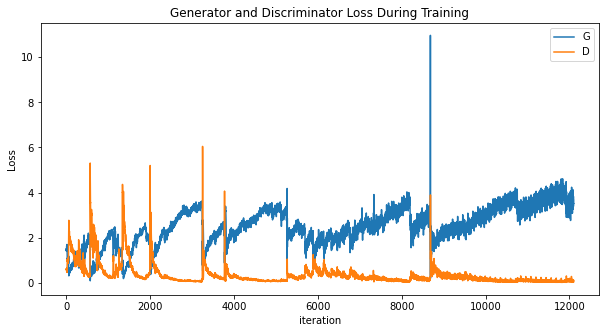

In [45]:
plt.figure(figsize=(10,5))
plt.title('Generator and Discriminator Loss During Training')
plt.plot(G_losses, label='G')
plt.plot(D_losses, label='D')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

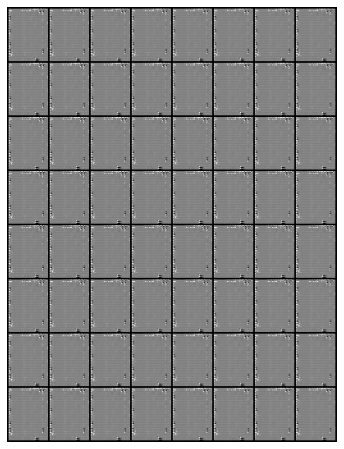

In [46]:
fig = plt.figure(figsize=(8,8))
plt.axis('off')
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated = True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000,blit=True)

HTML(ani.to_jshtml())

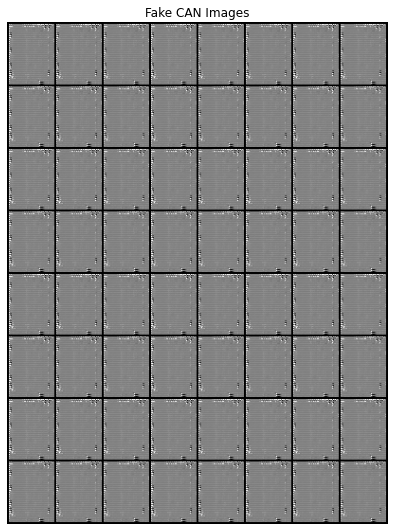

In [47]:
# bring real datas form dataloader
real_batch = next(iter(dataloader))

# print real images on display
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('Fake CAN Images')
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
# noise가 흰색 아니면 검은색만 되게 그값이 0 아니면 255로만 설정하자